# Deep Dive Into Genetic Algorithm🐢
> **작성자 : 오수지 (2022020660)**

안녕하세요, 고려대학교 산업경영공학부 DSBA 연구실 석사과정 오수지입니다.  
이번 노트북 튜토리얼에선 Dimensionality Reduction의 여러가지 방법론 중 Feature Selection 방법에 속하는 **`Genetic Algorithm`**에 대해 코드를 통해 알아볼 예정입니다.  
Genetic Algorithm은 인간의 뇌를 모방해서 탄생한 Neural Network처럼 진화론의 자연선택설에 기반해서 탄생한 방법론입니다.  
그렇기 때문에 방법론을 이해하는건 무척이나 쉽습니다!💡  
여러 변수 조합을 생성한 뒤 그 중 성능이 좋은 우수한 변수 조합을 **선택(Selection)**하고 그들끼리 **교배(Crossover)**시켜 또 다른 변수 조합을 생성하고, 너무 획일화된 변수 조합만이 생성되어 Local Optimum에 빠지는 것을 방지하기 위해 중간중간 **돌연변이(Mutation)**도 생성시키고... 최종적으로 성능이 가장 좋았던 변수 조합을 선택하면 끝!

<img src="https://github.com/ohsuz/2022-2-Business-Analytics-Assignments/blob/main/images/2_ga.png?raw=true" width="450">

방법론은 간단하지만 제가 만약 태초에 신이 되어 자연선택설로 인간을 진화시켜야 하는 자리에 놓였다면 고민해봐야 될 게 매우 많을 것 같습니다.  
일단 처음 인간 수를 몇명으로 둘지도 정해야하고, 어떤 기준으로 우수한 인간을 선택해야 될지도 고민이 되고, 돌연변이 비율은 또 얼마로 주어야하며, 어느 정도 쯤에서 교배를 멈추고 최종적으로 우수한 인간을 선택해야 하는지도 고민이 되고...

이처럼 Genetic Algorithm에 있어선 다양한 선택지, 즉 하이퍼파라미터가 있고, 선택지에 따라 결과도 아마 달라질텐데요.  

이번 노트북에선 크게 **총 3가지의 선택지**에 대한 결과를 확인해보겠습니다! (튜토리얼은 귀여운 거북이🐢를 예시로 진행될 예정입니다.)
>1. 거북이 개체수를 몇개로 시작해야 될까요? (`The number of population`)
2. 우수한 거북이를 교배시킬 때 Crossover point에 따라 결과에 차이가 어떻게 있을까요? (`Crossover mechanism`)
3. 다양한 거북이를 생성시키기 위한 돌연변이 비율은 어떻게 주어야 할까요? (`The rate of mutation`)


📌 노트북에 사용된 모든 거북이 관련 이미지는 [generativedesign](https://www.generativedesign.org/02-deeper-dive/02-04_genetic-algorithms/02-04-01_what-is-a-genetic-algorithm)에서 가져왔습니다.  

## 🛠 환경 설정

In [1]:
import numpy as np
import pandas as pd
import random
from scipy.special import softmax
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm
import easydict
import seaborn as sns
import copy

---

## 0️⃣ 데이터 준비
> 튜토리얼을 위해 사용할 수 있는 데이터엔 다음과 같은 데이터들이 있습니다. 이 중 다양한 하이퍼파라미터에 대해 빠르게 실험을 해보기 위해서 '적은 데이터 개수'를 갖고, 차원 축소의 의의에 맞게 '적당히 많은 변수 개수'를 갖는 **`ToyotaCorolla`** 데이터를 사용하겠습니다. (오리지널 데이터의 경우 카테고리 변수까지 고려하게 되면 변수의 개수가 300개가 넘어서 캐글용으로 정제된 데이터를 사용했습니다.)


<img src="https://github.com/ohsuz/2022-2-Business-Analytics-Assignments/blob/main/images/1_data.png?raw=true" width="450">

In [2]:
data = pd.read_csv('data/ToyotaCorolla.csv')
data.head(3)

,Price,Age,KM,FuelType,HP,MetColor,Automatic,CC,Doors,Weight
0,13500,23,46986,Diesel,90,1,0,2000,3,1165
1,13750,23,72937,Diesel,90,1,0,2000,3,1165
2,13950,24,41711,Diesel,90,1,0,2000,3,1165


In [3]:
data = pd.get_dummies(data)
data.head()

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight,FuelType_CNG,FuelType_Diesel,FuelType_Petrol
0,13500,23,46986,90,1,0,2000,3,1165,0,1,0
1,13750,23,72937,90,1,0,2000,3,1165,0,1,0
2,13950,24,41711,90,1,0,2000,3,1165,0,1,0
3,14950,26,48000,90,0,0,2000,3,1165,0,1,0
4,13750,30,38500,90,0,0,2000,3,1170,0,1,0


In [4]:
X = data.drop('Price', axis = 1).values
y = data.iloc[:, 0].values.reshape(-1,1)

In [5]:
X.shape, y.shape

((1436, 11), (1436, 1))

---

## 1️⃣ Initialization

> 거북이를 처음 만들 땐 거북이 다리 길이, 거북이 피부색, 등껍질 색 등 다양한 고려사항이 있습니다. 이 모든 요소들을 일일이 선택해서 거북이를 만들기엔 시간이 많이 소요되니 랜덤하게 초기화를 시켜주겠습니다! 각 거북이마다 변수별로 랜덤하게 0~1 사이의 난수를 생성한 다음 cut off 이상인 수는 1로, 아닌 수는 0으로 초기화를 시켜줍니다.  

> ① **n_pop** : 초기 거북이 개체수  
② **cut_off** : 0과 1을 분류하는 threshold

<img src="https://github.com/ohsuz/2022-2-Business-Analytics-Assignments/blob/main/images/3_initialization.png?raw=true" width="600">


In [6]:
def initialize(n_pop, cut_off):
    population = np.random.rand(n_pop, X.shape[-1])
    population = np.where(population < cut_off, 0, 1)
    return population

In [7]:
turtles = initialize(n_pop=50, cut_off=0.5)

In [8]:
len(turtles)

50

In [9]:
turtles[:5]

array([[1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1],
       [0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1]])

## 2️⃣ Fitness Evaluation
> 현재 주어진 거북이 중 다음 세대로 유전자를 넘겨줄 거북이를 정하려면 어떤 거북이가 가장 우수한 거북인지 알아야 합니다. 거북이의 점수를 매기는 기준은 지능, 싸움 능력 등 다양하고, 실제로 사용되는 Fitness Function도 다양하지만 현재 실험해야 할 하이퍼파라미터가 많으므로 Fitness function과 Fitness Score는 Linear Regression과 R-squared score로 고정하겠습니다!

>① **Fitness function** : Linear Regression  
② **Fitness Score** : R-squared score, RMSE

<img src="https://github.com/ohsuz/2022-2-Business-Analytics-Assignments/blob/main/images/4_eval_1.png?raw=true" width="550">
<img src="https://github.com/ohsuz/2022-2-Business-Analytics-Assignments/blob/main/images/5_eval_2.png?raw=true" width="550">

In [10]:
def score_func(func_name):
    if func_name == 'r2':
        return metrics.r2_score
    if func_name == 'rmse':
        return metrics.mean_squared_error

- 시작하기 앞서, 전체 변수를 다 활용했을 때의 성능은 어느정도인지 확인해봅시다!

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

regressor_linear = LinearRegression()
regressor_linear.fit(X_train_scaled, y_train)
y_pred = regressor_linear.predict(X_test_scaled)
r2_score = score_func('r2')(y_test, y_pred)
rmse_score = np.sqrt(score_func('rmse')(y_test, y_pred))

print(f'r2 : {r2_score:.3}, rmse : {rmse_score:.3}')

r2 : 0.852, rmse : 1.4e+03


In [14]:
scores = {}

for idx, turtle in enumerate(turtles):
    turtle_genes = X[:, np.where(turtle==1)].squeeze()
    if X[:, np.where(turtle==1)].shape[-1] == 1:
        turtle_genes = np.expand_dims(turtle_genes, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(turtle_genes, y, test_size = 0.2, random_state = 42)
    
    sc = StandardScaler()
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.fit_transform(X_test)
    regressor_linear = LinearRegression()
    regressor_linear.fit(X_train_scaled, y_train)

    y_pred = regressor_linear.predict(X_test_scaled)
    score = score_func('r2')(y_test, y_pred)
    
    scores[idx] = score

In [15]:
scores.values()

dict_values([0.8383485756077108, 0.5964302366036484, 0.8233836738302189, 0.3341561769905066, -4.180154100236597e+22, 0.8388747267074725, 0.4568729899687971, 0.8286120813218595, 0.8136732975174821, 0.7988709405354976, 0.8282463287454004, 0.8274141289022657, 0.5935427053275624, 0.5843116089143525, -4.008415983544975e+23, 0.7734586766115362, 0.8007188024343581, 0.828209722992841, 0.8004641185404253, 0.5830416796966877, 0.7985295940751872, 0.6256725687475557, -9.170450163522574e+22, 0.5963113446242585, 0.5597729136215464, 0.4825104179023205, 0.8537885086699165, 0.5851273063302638, -1.4454393203536776e+24, 0.6089830722880363, 0.8459060684462884, 0.8296381440374371, 0.7639037331612644, 0.8226847513233428, 0.8262874975988292, 0.3752333017869597, 0.18731753563125386, 0.6139251448298022, 0.569612382798516, -5.348864117967578e+21, 0.7986175888736617, 0.8244839094048009, 0.8355206264168439, 0.8139202596053215, 0.8338925854772005, 0.45637608403134566, 0.31278181364593793, 0.7847982752185999, 0.838

In [16]:
def evaluation(turtles, score_name='r2'):
    scores = {}

    for idx, turtle in enumerate(turtles):
        turtle_genes = X[:, np.where(turtle==1)].squeeze()
        if X[:, np.where(turtle==1)].shape[-1] == 0:
            continue
        if X[:, np.where(turtle==1)].shape[-1] == 1:
            turtle_genes = np.expand_dims(turtle_genes, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(turtle_genes, y, test_size = 0.2, random_state = 42)

        sc = StandardScaler()
        X_train_scaled = sc.fit_transform(X_train)
        X_test_scaled = sc.fit_transform(X_test)
        regressor_linear = LinearRegression()
        regressor_linear.fit(X_train_scaled, y_train)

        y_pred = regressor_linear.predict(X_test_scaled)
        score = score_func(score_name)(y_test, y_pred)
        if score_name == 'rmse':
            score = np.sqrt(score)

        scores[idx] = score
    
    return scores

## 3️⃣ Selection
> 모든 거북이에게 점수를 다 매겼다면 이제 정말 유전자를 다음 세대로 넘겨줄 부모 거북이를 선택해야 하는 시간이 다가왔습니다! 정말 단호하게 상위 N%의 거북이만을 선택하는 방법도 있고(`Deterministic`), 그래도 모든 거북이에게 기회를 주자는 의미에서 거북이의 점수를 가중치로 사용해서 랜덤하게 거북이를 선택하는 방법도 있습니다(`Probabilistic`). 각 방법에 따른 결과의 차이는 뒤에서 확인해보겠습니다!

> ① **method** : Deterministic vs Probabilistic  
② **top_n** : method가 Deterministic인 경우, 상위 몇 퍼센트를 선택할건지  
③ **n_pop** : method가 Probabilistic인 경우, 최종 몇 개의 부모를 선택할지

<img src="https://github.com/ohsuz/2022-2-Business-Analytics-Assignments/blob/main/images/6_selection.png?raw=true" width="550">

In [17]:
def select_parent_turtles(turtles, scores, method, top_n=0.5, top_n_pop=20):
    parent_idxs = []
    if method == 'deterministic':
        top_n_pop = int(np.round(len(scores) * top_n))
        if top_n_pop %2 != 0:
            top_n_pop -= 1
        parent_idxs = [idx for idx, score in sorted(scores.items(), key=lambda x: x[1], reverse=True)][:top_n_pop]
    if method == 'probabilistic':
        softmax_scores = softmax(list(scores.values()))
        parent_idxs = list(np.random.choice(list(scores.keys()), top_n_pop, p=list(softmax_scores), replace=True))
    parent_turtles = turtles[parent_idxs]
    best_idx, best_score = [(idx, score) for idx, score in sorted(scores.items(), key=lambda x: x[1], reverse=True)][0]
    best_parent = turtles[best_idx]
    return parent_turtles, best_parent, best_score

In [18]:
parents, best_parent, best_score = select_parent_turtles(turtles, scores, 'deterministic', top_n=0.5)

In [19]:
parents, best_parent, best_score

(array([[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1],
        [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0],
        [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0],
        [1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0],
        [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0],
        [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1],
        [1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0],
        [1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0],
        [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0],
        [1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0],
        [1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1],
        [1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
        [1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1],
        [1,

## 4️⃣ Crossover & Mutation
> 이제 부모 거북이까지 선택이 끝났으니 교배를 통해 아기 거북이를 만들어볼 시간입니다! 몇 개의 지점에서 유전자를 교환할지를 나타내는 Crossover point 개수에 따라서 부모 거북이와 비슷한 유전자 조합을 가진 아기 거북이가 만들어질수도, 완전히 다른 유전자 조합을 가지는 아기 거북이가 만들어질 수도 있습니다. 마지막으로 아기 거북이의 다양성을 위해 고안된 `Mutation` 단계가 있습니다. 교배가 완료된 아기 거북이의 유전자를 랜덤하게 정반대로 바꿔서 아래와 같이 보라색 거북이를 탄생시키기 위한 과정인데 이때 Mutation Rate를 통해 돌연변이가 발생하는 유전자의 빈도를 대략적으로 조절할 수 있습니다.

> ① **Crossover point** : 1~N  
② **Crossover rate** : Crossover point가 N인 경우 어떤 유전자를 교체할지에 대한 cut-off  
③ **Mutation Rate** : 돌연변이를 발생시키기 위해 교체될 유전자에 대한 cut-off

<img src="https://github.com/ohsuz/2022-2-Business-Analytics-Assignments/blob/main/images/7_crossover.png?raw=true" width="550">
<img src="https://github.com/ohsuz/2022-2-Business-Analytics-Assignments/blob/main/images/8_mutation.png?raw=true" width="550">


In [20]:
def mutate(child1, child2, mutation_rate):
    child1_randn, child2_randn = np.random.rand(child1.shape[-1]), np.random.rand(child1.shape[-1])
    child1 = np.where(child1_randn < mutation_rate, child1, abs(child1-1))
    child2 = np.where(child2_randn < mutation_rate, child2, abs(child2-1))
    return child1, child2

In [21]:
def crossover(n_pop, parents, crossover_point, crossover_rate=0.5, mutation_rate=0.01):
    children = []
    while len(children) != n_pop:
        i, j = np.random.choice(len(parents), 2, replace=False)
        parent1, parent2 = parents[i], parents[j]
        
        # Case 1 : crossover_point = n
        if crossover_point == X.shape[-1]:
            swap_randn = np.random.rand(X.shape[-1])
            child1 = np.where(swap_randn < crossover_rate, parent1, parent2)
            child2 = np.where(swap_randn < crossover_rate, parent2, parent1)
            
        # Case 2 : crossover_point = 1~n-1
        else:
            child1, child2 = [], []
            crossover_points = np.sort(np.random.permutation(np.arange(1, X.shape[-1]))[:crossover_point])
            for idx, point in enumerate(crossover_points):
                if idx % 2 == 0:
                    if idx == 0:
                        child1.extend(list(parent1[:point]))
                        child2.extend(list(parent2[:point]))
                    else:
                        start, end = crossover_points[idx-1], point
                        child1.extend(list(parent1[start:end]))
                        child2.extend(list(parent2[start:end]))
                else:
                    start, end = crossover_points[idx-1], point
                    child1.extend(list(parent2[start:end]))
                    child2.extend(list(parent1[start:end]))
            if (idx+1) % 2 == 0:
                child1.extend(list(parent1[point:]))
                child2.extend(list(parent2[point:]))
            else:
                child1.extend(list(parent2[point:]))
                child2.extend(list(parent1[point:]))
            child1, child2 = np.array(child1), np.array(child2)
            
        # Mutation
        child1, child2 = mutate(child1, child2, mutation_rate)
        children.append(child1)
        children.append(child2)
        
    return np.array(children)

In [22]:
crossover(10, parents, 11)

array([[0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1],
       [0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]])

## 5️⃣ Final Genetic Algorithm 🎉
> 최종 Genetic Algorithm이 완성됐습니다!🥳 
그럼 이제 argument들을 하나씩 바꿔가며 각 하이퍼파라미터에 따른 변화를 확인해봅시다.

<img src="https://github.com/ohsuz/2022-2-Business-Analytics-Assignments/blob/main/images/2_ga.png?raw=true" width="450">


In [23]:
def genetic_algorithm(args):
    turtles = initialize(n_pop=args.init_pop, cut_off=args.cut_off)
    best_parents, best_scores = [], []
    for epoch in tqdm(range(args.n_epochs)):
        scores = evaluation(turtles, score_name=args.score_name)
        parents, best_parent, best_score = select_parent_turtles(turtles, scores, args.method, top_n=args.top_n, top_n_pop=args.top_n_pop)
        best_parents.append(best_parent) 
        best_scores.append(round(best_score, 3))
        children = crossover(args.n_pop, parents, args.crossover_point, args.crossover_rate, args.mutation_rate)
        turtles = children
    history = pd.DataFrame.from_dict({'Generation': list(range(args.n_epochs)),
                                      'Best Score': best_scores,
                                      'Best Parents': best_parents})
    return history

In [24]:
def visualize(history):
    column_names = list(data.columns)[1:]
    best_idx = list(history['Best Score']).index(max(list(history['Best Score'])))
    best_parent = list(history['Best Parents'])[best_idx]
    best_columns = ', '.join([column_names[idx] for idx, gene in enumerate(best_parent) if gene==1])
    print('Final Best Score : ', max(list(history['Best Score'])))
    print('Final Selected Variables : ', best_columns)
    sns.lineplot(x='Generation', y='Best Score', data=history) 

- 가장 기본 세팅에서의 성능을 확인해봅시다!

In [25]:
base_args = easydict.EasyDict({
    "n_epochs" : 50,
    "init_pop" : 50,
    "n_pop" : 50,
    "cut_off" : 0.5,
    "score_name" : 'r2',
    "method" : 'deterministic',
    "top_n" : 0.5,
    "top_n_pop" : 25,
    "crossover_point" : 11,
    "crossover_rate" : 0.5,
    "mutation_rate" : 0.01
})

In [26]:
base_history = genetic_algorithm(base_args)

  0%|          | 0/50 [00:00<?, ?it/s]

> 데이터의 개수도 적고, 변수 개수도 적기 때문인지 초반부터 전체 변수를 사용했을 때의 성능과 비슷한 정도의 높은 score를 달성하고, 세대를 거듭해도 일정 score에 수렴하지는 못하는 결과를 확인할 수 있었습니다.

Final Best Score :  0.853
Final Selected Variables :  Age, KM, HP, Automatic, CC, Doors, FuelType_CNG, FuelType_Diesel


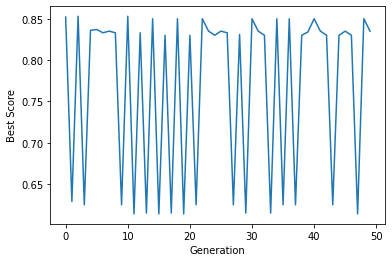

In [27]:
visualize(base_history)

### The number of Initial Population : Small vs Big
> 매 세대마다 세대수는 일정한 상황에서 초기 개체수의 대소와는 상관없이 비슷한 최고 성능, 비슷한 경향을 띄는 그래프가 그려지는 걸 확인할 수 있었습니다. 그럼 세대수에 따른 차이는 있을까요?

  0%|          | 0/50 [00:00<?, ?it/s]

Final Best Score :  0.853
Final Selected Variables :  Age, KM, HP, MetColor, Automatic, CC, Doors, FuelType_CNG, FuelType_Diesel


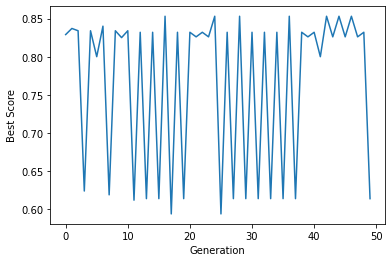

In [28]:
small_init_args = copy.deepcopy(base_args)
small_init_args.init_pop = 10
visualize(genetic_algorithm(small_init_args))

  0%|          | 0/50 [00:00<?, ?it/s]

Final Best Score :  0.853
Final Selected Variables :  Age, KM, HP, Automatic, CC, Doors, FuelType_CNG, FuelType_Diesel


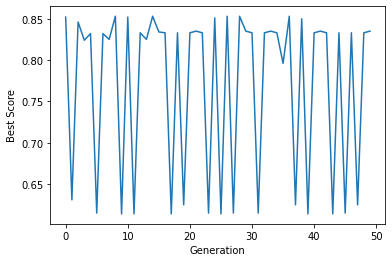

In [29]:
big_init_args = copy.deepcopy(base_args)
big_init_args.init_pop = 100
visualize(genetic_algorithm(big_init_args))

### The number of Population : Small vs Big
> 비록 베이스가 되는 그래프부터 이상적인 모습의 그래프 모양이 아니었기 때문에 제대로 된 비교는 힘들지만 비교적 탐색 범위가 적은 Small Population 그래프가 Big Population 그래프에 비해 초중반에 Score의 변동성이 적은 것을 확인해볼 수 있었습니다.

  0%|          | 0/50 [00:00<?, ?it/s]

Final Best Score :  0.856
Final Selected Variables :  Age, KM, HP, Automatic, CC, Weight, FuelType_Diesel


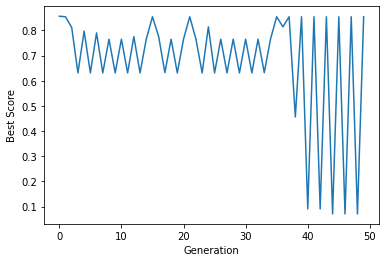

In [30]:
small_pop_args = copy.deepcopy(base_args)
small_pop_args.n_pop = 10
visualize(genetic_algorithm(small_pop_args))

  0%|          | 0/50 [00:00<?, ?it/s]

Final Best Score :  0.854
Final Selected Variables :  Age, KM, HP, MetColor, Automatic, Doors, Weight


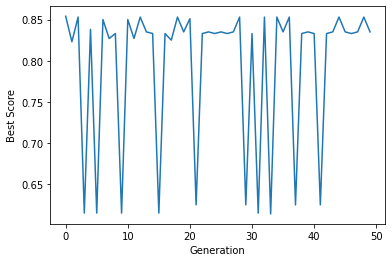

In [31]:
big_pop_args = copy.deepcopy(base_args)
big_pop_args.n_pop = 100
visualize(genetic_algorithm(big_pop_args))

### Selection : Deterministic vs Probabilistic

  0%|          | 0/50 [00:00<?, ?it/s]

Final Best Score :  0.855
Final Selected Variables :  Age, KM, HP, Automatic, CC, Doors, Weight, FuelType_Diesel


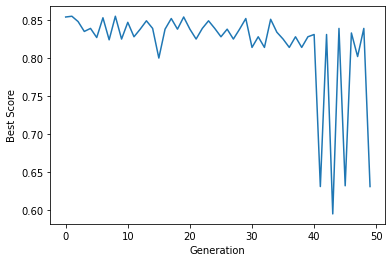

In [33]:
prob_args = copy.deepcopy(base_args)
prob_args.method = 'probabilistic'
visualize(genetic_algorithm(prob_args))

### Crossover Point : 1 vs 5 vs 10

In [34]:
cp1_args = copy.deepcopy(base_args)
cp1_args.crossover_point = 1
cp5_args = copy.deepcopy(base_args)
cp5_args.crossover_point = 5
cp10_args = copy.deepcopy(base_args)
cp10_args.crossover_point = 10

  0%|          | 0/50 [00:00<?, ?it/s]

Final Best Score :  0.853
Final Selected Variables :  Age, KM, HP, Automatic, CC, Doors, FuelType_Diesel, FuelType_Petrol


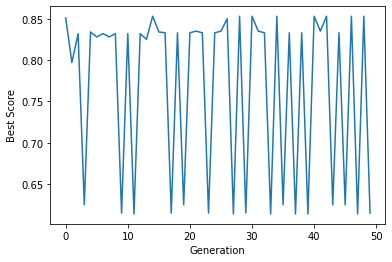

In [35]:
visualize(genetic_algorithm(cp1_args))

  0%|          | 0/50 [00:00<?, ?it/s]

Final Best Score :  0.853
Final Selected Variables :  Age, KM, HP, Automatic, CC, Doors, FuelType_Diesel


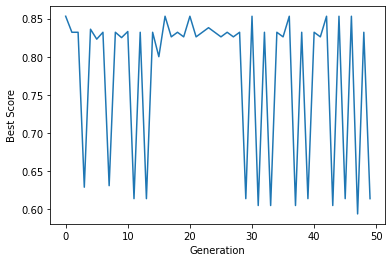

In [36]:
visualize(genetic_algorithm(cp5_args))

  0%|          | 0/50 [00:00<?, ?it/s]

Final Best Score :  0.856
Final Selected Variables :  Age, KM, HP, MetColor, Automatic, CC, Weight, FuelType_Diesel


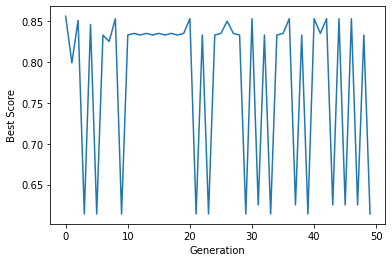

In [37]:
visualize(genetic_algorithm(cp10_args))

### Mutation Rate : 0.1 vs 0.9
> Mutation Rate이 클수록 수렴하기까지 시간이 오래 걸린다는 사실을 직접 확인해보고 싶었으나 위와 같은 이유로 눈에 띄는 차이는 확인되지 않았습니다. 오히려 기대와는 반대로 Mutation Rate이 비이상적으로 클 때가 작을 때보다 더 적은 변동폭을 보이는 경향을 확인해볼 수 있었습니다. 

  0%|          | 0/50 [00:00<?, ?it/s]

Final Best Score :  0.854
Final Selected Variables :  Age, KM, HP, MetColor, Automatic, Doors, Weight, FuelType_CNG


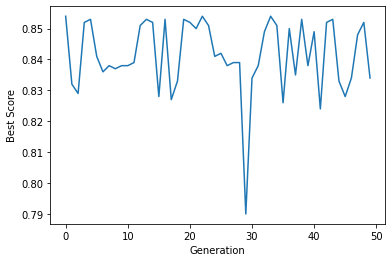

In [38]:
mut_01_args = copy.deepcopy(base_args)
mut_01_args.mutation_rate = 0.1
visualize(genetic_algorithm(mut_01_args))

  0%|          | 0/50 [00:00<?, ?it/s]

Final Best Score :  0.856
Final Selected Variables :  Age, KM, HP, MetColor, Automatic, CC, Weight, FuelType_Diesel


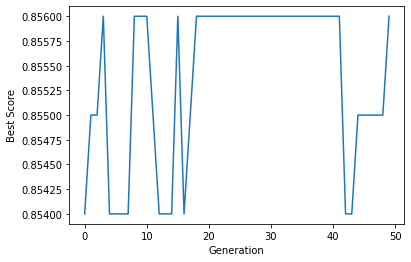

In [40]:
mut_09_args = copy.deepcopy(base_args)
mut_09_args.mutation_rate = 0.9
visualize(genetic_algorithm(mut_09_args))

> 비록 기대했던 실험 결과는 얻어내지 못했지만 Genetic Algorithm에 대해 깊게 탐구해볼 수 있는 유익한 시간이었습니다. 그럼 다음 튜토리얼에 `SVM`으로 다시 찾아뵙겠습니다.

<img src="https://github.com/ohsuz/2022-2-Business-Analytics-Assignments/blob/main/images/9_turtle.png?raw=true" width="300">
